In [37]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from model import SRNets, SRNet, AutoLUT, round_func
import sys
sys.path.insert(0, "../")
from common.network import MuLUTUnit, SRNet, Residual, AutoSample
import torch
import numpy as np
from torch.nn import functional as F
from PIL import Image
from matplotlib import pyplot as plt
import torchvision

network=SRNets(3, 3).cuda().eval()
ckpt=torch.load("../models/no_res_bug/3x3-export/Model_800000.pth")
network.load_state_dict(ckpt.state_dict(), strict=True)
lutnet=AutoLUT("../models/no_res_bug/3x3-export", 2, 3, 3).cuda().eval()

def showimg(image, plot=plt):
    # N,C,H,W -> H,W,C
    image=np.array(image.detach().cpu())
    N,C,H,W=image.shape
    assert N==1
    image=image.reshape(C,H,W).transpose(1,2,0)
    if plot==plt: plt.figure()
    plot.imshow(image, cmap='gray' if C==1 else None, vmin=0, vmax=1)

def psnr(a,b):
    from common.utils import PSNR, _rgb2ycbcr
    def transform(x):
        x=x*255
        x=x.squeeze(0)
        x=torch.transpose(x, 0, 1)
        x=torch.transpose(x, 1, 2)
        x=torch.clamp(x, 0, 255)
        x=torch.round(x).to(torch.uint8)
        return x

    a=transform(a)
    b=transform(b)
    left, right = _rgb2ycbcr(a)[:,:,0], _rgb2ycbcr(b)[:,:,0]
    result=PSNR(left, right, 4)
    return result,a,b


/tmp/ipykernel_1278926/4056868467.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load("../models/no_res_bug/3x3-export/Model_800000.pth")


tensor([[[[0.5252, 0.9092, 0.7998],
          [0.1844, 0.1096, 0.6927],
          [1.0000, 0.9297, 0.8153]]]], device='cuda:0')


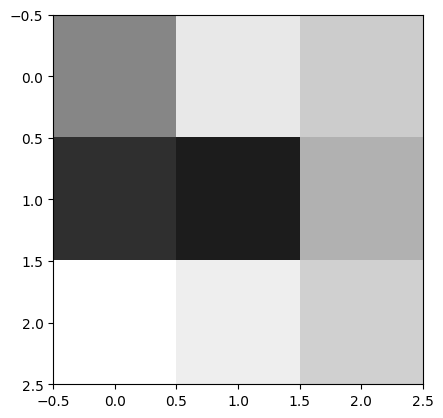

In [51]:
N,C,H,W=1,1,3,3
# small_img=torch.Tensor([1,5,8,9,6,5,4,8,7,3,4,6,6,5,3,4,5,5,3,2,1,0,9,7,5][:N*C*H*W]).cuda()
# small_img=torch.ones_like(small_img)
small_img = torch.rand(N,C,H,W).cuda()
small_img=small_img.reshape([N,C,H,W])
small_img=small_img/small_img.max()
showimg(small_img)
print(small_img)

tensor([[[[0.8859, 0.3009],
          [0.8051, 0.6822]]]], device='cuda:0',
       grad_fn=<PixelShuffleBackward0>)
tensor([[[[0.8859, 0.3009],
          [0.8051, 0.6822]]]], device='cuda:0', grad_fn=<CatBackward0>)


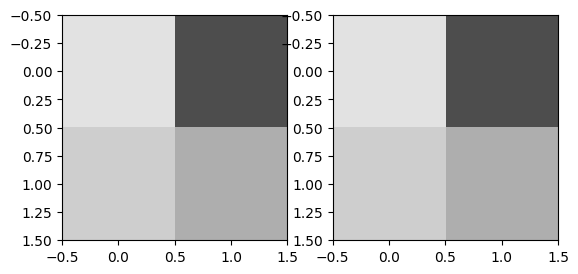

In [39]:
# Sample
fig, (pa,pb)=plt.subplots(1,2)
key='s0_1'

# sr net
module=getattr(network, key)
sampled=module.sampler(small_img)
showimg(sampled,pa)
print(sampled)

# lut
sampler=getattr(lutnet, key+'_sampler')
a,b,c,d=lutnet.sample(sampler,small_img)
up=torch.concat([a,b], dim=3)
down=torch.concat([c,d], dim=3)
lut_sampled=torch.concat([up,down], dim=2)
showimg(lut_sampled,pb)
print(lut_sampled)

assert (sampled==lut_sampled).all()

tensor(-1., device='cuda:0', grad_fn=<MinBackward1>) tensor(-1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([[[[0.]]]], device='cuda:0', grad_fn=<DivBackward0>)
ups plus tensor([[[[0.]]]], device='cuda:0', grad_fn=<DivBackward0>)
ups minus tensor([[[[0.5585]]]], device='cuda:0', grad_fn=<DivBackward0>)
tensor(-127., device='cuda:0', grad_fn=<MinBackward1>) tensor(-127., device='cuda:0', grad_fn=<MaxBackward1>)
tensor([[[[0.0039]]]], device='cuda:0', grad_fn=<DivBackward0>)


tensor([[[[-0.0039]]]], device='cuda:0', grad_fn=<SubBackward0>)

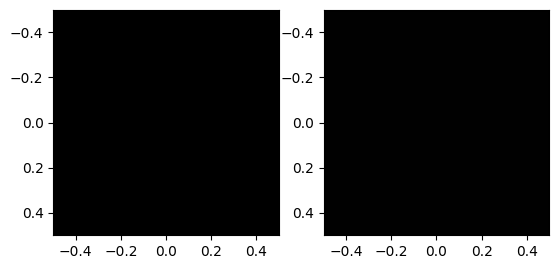

In [40]:
# One MuLUTUnit
key = 's0_0'
fig, (pa, pb,)=plt.subplots(1,2)

# sr net
module=getattr(network, key)
upscaled=module(small_img)
print(upscaled.min(), upscaled.max())
upscaled=(upscaled+1)/2
showimg(upscaled,pa)
print(upscaled)

# lut+1
ups_plus=module((small_img*255+1)/255)
ups_plus=(ups_plus+1)/2
print("ups plus",ups_plus)

# lut
ups_minus=module(torch.ones_like(small_img)*240/255)
ups_minus=(ups_minus+1)/2
print("ups minus",ups_minus)

# lut
lut_ups=lutnet.InterpTorchBatch(
    getattr(lutnet, 'weight_'+key), getattr(lutnet, key+'_residual'), getattr(lutnet, key+'_sampler'),
    1, small_img*255, None, 3-1
)
print(lut_ups.min(), lut_ups.max())
lut_ups=(lut_ups+128)/255
showimg(lut_ups, pb)
print(lut_ups)

upscaled-lut_ups

In [41]:
print("upscaled:", upscaled.reshape(-1)[0]*255)
print("lut:", lut_ups.reshape(-1)[0]*255)

upscaled: tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
lut: tensor(1., device='cuda:0', grad_fn=<MulBackward0>)


In [42]:
srnet=getattr(network, key)
unfolded, shape=srnet.unfold(small_img)
sampled=srnet.sampler(unfolded)
ups=srnet.model(sampled)
upscaled=srnet.put_back(ups, shape)
display(upscaled)
stored_lut=(upscaled*127).to(torch.int8) #-128~127
color=stored_lut.reshape(-1)[0].to(torch.float)
display((color+127)/255)

stored_next=(upscaled*127+1).to(torch.int8)
color=stored_next.reshape(-1)[0].to(torch.float)
display((color+127)/255)

tensor([[[[-1.]]]], device='cuda:0', grad_fn=<Col2ImBackward0>)

tensor(0., device='cuda:0')

tensor(0.0039, device='cuda:0')

diff tensor(-45., device='cuda:0', grad_fn=<MinBackward1>) tensor(22.0000, device='cuda:0', grad_fn=<MaxBackward1>)


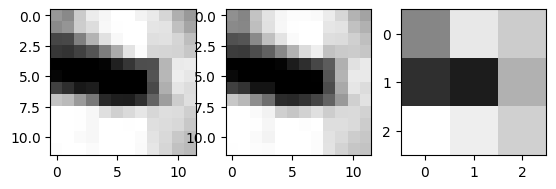

In [56]:
fig, (pa, pb, pc, )=plt.subplots(1,3)
sr_upscaled=network(small_img)
lut_upscaled=lutnet(small_img)
showimg(small_img, pc)
showimg(sr_upscaled,pa)
showimg(lut_upscaled,pb)
diff=(sr_upscaled-lut_upscaled)*255
print("diff", diff.min(), diff.max())

In [44]:
def InterpTorchBatch(self, weight: torch.Tensor, res_w: torch.Tensor, sampler: AutoSample,
                         upscale, img_in, prev_img, bd, sample=True):
        _, _, h, w = img_in.shape
        h -= bd
        w -= bd

        weight = weight * 127
        weight = self.round_func(weight)
        weight = torch.clamp(weight, -127, 127)

        interval = self.interval
        q = 2 ** interval
        L = 2 ** (8 - interval) + 1

        # Auto Sample
        if sample:
            a,b,c,d=self.sample(sampler, img_in)
        else:
            assert img_in.shape==(1,1,2,2)
            a,b,c,d=img_in.reshape(-1)
            a=a.reshape(1,1,1,1)
            b=b.reshape(1,1,1,1)
            c=c.reshape(1,1,1,1)
            d=d.reshape(1,1,1,1)


        # Residual
        if prev_img != None:
            res_w = torch.clamp(res_w, 0, 1)
            oa,ob,oc,od=a,b,c,d
            pa,pb,pc,pd=self.sample(sampler, prev_img)

            a = res_w[0][0]*pa + (1-res_w[0][0])*oa
            b = res_w[0][1]*pb + (1-res_w[0][1])*ob
            c = res_w[1][0]*pc + (1-res_w[1][0])*oc
            d = res_w[1][1]*pd + (1-res_w[1][1])*od

        img_a1 = torch.floor_divide(a, q).type(torch.int64)
        img_b1 = torch.floor_divide(b, q).type(torch.int64)
        img_c1 = torch.floor_divide(c, q).type(torch.int64)
        img_d1 = torch.floor_divide(d, q).type(torch.int64)
        # print("abcd:", img_a1,img_b1,img_c1,img_d1)
        # print("abcd*2**4", img_a1*2**4,img_b1*2**4,img_c1*2**4,img_d1*2**4)

        fa = a % q
        fb = b % q
        fc = c % q
        fd = d % q

        img_a2 = img_a1 + 1
        img_b2 = img_b1 + 1
        img_c2 = img_c1 + 1
        img_d2 = img_d1 + 1

        p0000 = weight[img_a1.flatten() * L * L * L + img_b1.flatten() * L * L + img_c1.flatten() * L + img_d1.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p0001 = weight[img_a1.flatten() * L * L * L + img_b1.flatten() * L * L + img_c1.flatten() * L + img_d2.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p0010 = weight[img_a1.flatten() * L * L * L + img_b1.flatten() * L * L + img_c2.flatten() * L + img_d1.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p0011 = weight[img_a1.flatten() * L * L * L + img_b1.flatten() * L * L + img_c2.flatten() * L + img_d2.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p0100 = weight[img_a1.flatten() * L * L * L + img_b2.flatten() * L * L + img_c1.flatten() * L + img_d1.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p0101 = weight[img_a1.flatten() * L * L * L + img_b2.flatten() * L * L + img_c1.flatten() * L + img_d2.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p0110 = weight[img_a1.flatten() * L * L * L + img_b2.flatten() * L * L + img_c2.flatten() * L + img_d1.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p0111 = weight[img_a1.flatten() * L * L * L + img_b2.flatten() * L * L + img_c2.flatten() * L + img_d2.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))

        p1000 = weight[img_a2.flatten() * L * L * L + img_b1.flatten() * L * L + img_c1.flatten() * L + img_d1.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p1001 = weight[img_a2.flatten() * L * L * L + img_b1.flatten() * L * L + img_c1.flatten() * L + img_d2.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p1010 = weight[img_a2.flatten() * L * L * L + img_b1.flatten() * L * L + img_c2.flatten() * L + img_d1.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p1011 = weight[img_a2.flatten() * L * L * L + img_b1.flatten() * L * L + img_c2.flatten() * L + img_d2.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p1100 = weight[img_a2.flatten() * L * L * L + img_b2.flatten() * L * L + img_c1.flatten() * L + img_d1.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p1101 = weight[img_a2.flatten() * L * L * L + img_b2.flatten() * L * L + img_c1.flatten() * L + img_d2.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p1110 = weight[img_a2.flatten() * L * L * L + img_b2.flatten() * L * L + img_c2.flatten() * L + img_d1.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        p1111 = weight[img_a2.flatten() * L * L * L + img_b2.flatten() * L * L + img_c2.flatten() * L + img_d2.flatten()
                       ].reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))

        out = torch.zeros((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2],
                           img_a1.shape[3], upscale, upscale), dtype=weight.dtype).to(device=weight.device)
        sz = img_a1.shape[0] * img_a1.shape[1] * img_a1.shape[2] * img_a1.shape[3]
        out = out.reshape(sz, -1)

        p0000 = p0000.reshape(sz, -1)
        p0100 = p0100.reshape(sz, -1)
        p1000 = p1000.reshape(sz, -1)
        p1100 = p1100.reshape(sz, -1)
        fa = fa.reshape(-1, 1)

        p0001 = p0001.reshape(sz, -1)
        p0101 = p0101.reshape(sz, -1)
        p1001 = p1001.reshape(sz, -1)
        p1101 = p1101.reshape(sz, -1)
        fb = fb.reshape(-1, 1)
        fc = fc.reshape(-1, 1)

        p0010 = p0010.reshape(sz, -1)
        p0110 = p0110.reshape(sz, -1)
        p1010 = p1010.reshape(sz, -1)
        p1110 = p1110.reshape(sz, -1)
        fd = fd.reshape(-1, 1)

        p0011 = p0011.reshape(sz, -1)
        p0111 = p0111.reshape(sz, -1)
        p1011 = p1011.reshape(sz, -1)
        p1111 = p1111.reshape(sz, -1)

        print("p0000", (p0000.to(torch.float)+128)/255)
        print("p1111", (p1111.to(torch.float)+128)/255)
        print("fabcd", fa,fb,fc,fd)

        fab = fa > fb;
        fac = fa > fc;
        fad = fa > fd

        fbc = fb > fc;
        fbd = fb > fd;
        fcd = fc > fd

        i1 = i = torch.all(torch.cat([fab, fbc, fcd], dim=1), dim=1)
        out[i] = (q - fa[i]) * p0000[i] + (fa[i] - fb[i]) * p1000[i] + (fb[i] - fc[i]) * p1100[i] + (fc[i] - fd[i]) * \
                 p1110[i] + (fd[i]) * p1111[i]
        i2 = i = torch.all(torch.cat([~i1[:, None], fab, fbc, fbd], dim=1), dim=1)
        out[i] = (q - fa[i]) * p0000[i] + (fa[i] - fb[i]) * p1000[i] + (fb[i] - fd[i]) * p1100[i] + (fd[i] - fc[i]) * \
                 p1101[i] + (fc[i]) * p1111[i]
        i3 = i = torch.all(torch.cat([~i1[:, None], ~i2[:, None], fab, fbc, fad], dim=1), dim=1)
        out[i] = (q - fa[i]) * p0000[i] + (fa[i] - fd[i]) * p1000[i] + (fd[i] - fb[i]) * p1001[i] + (fb[i] - fc[i]) * \
                 p1101[i] + (fc[i]) * p1111[i]
        i4 = i = torch.all(torch.cat([~i1[:, None], ~i2[:, None], ~i3[:, None], fab, fbc], dim=1), dim=1)
        out[i] = (q - fd[i]) * p0000[i] + (fd[i] - fa[i]) * p0001[i] + (fa[i] - fb[i]) * p1001[i] + (fb[i] - fc[i]) * \
                 p1101[i] + (fc[i]) * p1111[i]

        i5 = i = torch.all(torch.cat([~(fbc), fab, fac, fbd], dim=1), dim=1)
        out[i] = (q - fa[i]) * p0000[i] + (fa[i] - fc[i]) * p1000[i] + (fc[i] - fb[i]) * p1010[i] + (fb[i] - fd[i]) * \
                 p1110[i] + (fd[i]) * p1111[i]
        i6 = i = torch.all(torch.cat([~(fbc), ~i5[:, None], fab, fac, fcd], dim=1), dim=1)
        out[i] = (q - fa[i]) * p0000[i] + (fa[i] - fc[i]) * p1000[i] + (fc[i] - fd[i]) * p1010[i] + (fd[i] - fb[i]) * \
                 p1011[i] + (fb[i]) * p1111[i]
        i7 = i = torch.all(torch.cat([~(fbc), ~i5[:, None], ~i6[:, None], fab, fac, fad], dim=1), dim=1)
        out[i] = (q - fa[i]) * p0000[i] + (fa[i] - fd[i]) * p1000[i] + (fd[i] - fc[i]) * p1001[i] + (fc[i] - fb[i]) * \
                 p1011[i] + (fb[i]) * p1111[i]
        i8 = i = torch.all(torch.cat([~(fbc), ~i5[:, None], ~i6[:, None], ~i7[:, None], fab, fac], dim=1), dim=1)
        out[i] = (q - fd[i]) * p0000[i] + (fd[i] - fa[i]) * p0001[i] + (fa[i] - fc[i]) * p1001[i] + (fc[i] - fb[i]) * \
                 p1011[i] + (fb[i]) * p1111[i]

        i9 = i = torch.all(torch.cat([~(fbc), ~(fac), fab, fbd], dim=1), dim=1)
        out[i] = (q - fc[i]) * p0000[i] + (fc[i] - fa[i]) * p0010[i] + (fa[i] - fb[i]) * p1010[i] + (fb[i] - fd[i]) * \
                 p1110[i] + (fd[i]) * p1111[i]
        # Fix the overflow bug in SR-LUT's implementation, should compare fd with fa first!
        # i10 = i = torch.all(torch.cat([~(fbc), ~(fac), ~i9[:,None], fab, fcd], dim=1), dim=1)
        # out[i] = (q-fc[i]) * p0000[i] + (fc[i]-fa[i]) * p0010[i] + (fa[i]-fd[i]) * p1010[i] + (fd[i]-fb[i]) * p1011[i] + (fb[i]) * p1111[i]
        # i11 = i = torch.all(torch.cat([~(fbc), ~(fac), ~i9[:,None], ~i10[:,None], fab, fad], dim=1), dim=1)
        # out[i] = (q-fc[i]) * p0000[i] + (fc[i]-fd[i]) * p0010[i] + (fd[i]-fa[i]) * p0011[i] + (fa[i]-fb[i]) * p1011[i] + (fb[i]) * p1111[i]
        i10 = i = torch.all(torch.cat([~(fbc), ~(fac), ~i9[:, None], fab, fad], dim=1), dim=1)  # c > a > d > b
        out[i] = (q - fc[i]) * p0000[i] + (fc[i] - fa[i]) * p0010[i] + (fa[i] - fd[i]) * p1010[i] + (fd[i] - fb[i]) * \
                 p1011[i] + (fb[i]) * p1111[i]
        i11 = i = torch.all(torch.cat([~(fbc), ~(fac), ~i9[:, None], ~i10[:, None], fab, fcd], dim=1),
                            dim=1)  # c > d > a > b
        out[i] = (q - fc[i]) * p0000[i] + (fc[i] - fd[i]) * p0010[i] + (fd[i] - fa[i]) * p0011[i] + (fa[i] - fb[i]) * \
                 p1011[i] + (fb[i]) * p1111[i]
        i12 = i = torch.all(torch.cat([~(fbc), ~(fac), ~i9[:, None], ~i10[:, None], ~i11[:, None], fab], dim=1), dim=1)
        out[i] = (q - fd[i]) * p0000[i] + (fd[i] - fc[i]) * p0001[i] + (fc[i] - fa[i]) * p0011[i] + (fa[i] - fb[i]) * \
                 p1011[i] + (fb[i]) * p1111[i]

        i13 = i = torch.all(torch.cat([~(fab), fac, fcd], dim=1), dim=1)
        out[i] = (q - fb[i]) * p0000[i] + (fb[i] - fa[i]) * p0100[i] + (fa[i] - fc[i]) * p1100[i] + (fc[i] - fd[i]) * \
                 p1110[i] + (fd[i]) * p1111[i]
        i14 = i = torch.all(torch.cat([~(fab), ~i13[:, None], fac, fad], dim=1), dim=1)
        out[i] = (q - fb[i]) * p0000[i] + (fb[i] - fa[i]) * p0100[i] + (fa[i] - fd[i]) * p1100[i] + (fd[i] - fc[i]) * \
                 p1101[i] + (fc[i]) * p1111[i]
        i15 = i = torch.all(torch.cat([~(fab), ~i13[:, None], ~i14[:, None], fac, fbd], dim=1), dim=1)
        out[i] = (q - fb[i]) * p0000[i] + (fb[i] - fd[i]) * p0100[i] + (fd[i] - fa[i]) * p0101[i] + (fa[i] - fc[i]) * \
                 p1101[i] + (fc[i]) * p1111[i]
        i16 = i = torch.all(torch.cat([~(fab), ~i13[:, None], ~i14[:, None], ~i15[:, None], fac], dim=1), dim=1)
        out[i] = (q - fd[i]) * p0000[i] + (fd[i] - fb[i]) * p0001[i] + (fb[i] - fa[i]) * p0101[i] + (fa[i] - fc[i]) * \
                 p1101[i] + (fc[i]) * p1111[i]

        i17 = i = torch.all(torch.cat([~(fab), ~(fac), fbc, fad], dim=1), dim=1)
        out[i] = (q - fb[i]) * p0000[i] + (fb[i] - fc[i]) * p0100[i] + (fc[i] - fa[i]) * p0110[i] + (fa[i] - fd[i]) * \
                 p1110[i] + (fd[i]) * p1111[i]
        i18 = i = torch.all(torch.cat([~(fab), ~(fac), ~i17[:, None], fbc, fcd], dim=1), dim=1)
        out[i] = (q - fb[i]) * p0000[i] + (fb[i] - fc[i]) * p0100[i] + (fc[i] - fd[i]) * p0110[i] + (fd[i] - fa[i]) * \
                 p0111[i] + (fa[i]) * p1111[i]
        i19 = i = torch.all(torch.cat([~(fab), ~(fac), ~i17[:, None], ~i18[:, None], fbc, fbd], dim=1), dim=1)
        out[i] = (q - fb[i]) * p0000[i] + (fb[i] - fd[i]) * p0100[i] + (fd[i] - fc[i]) * p0101[i] + (fc[i] - fa[i]) * \
                 p0111[i] + (fa[i]) * p1111[i]
        i20 = i = torch.all(torch.cat([~(fab), ~(fac), ~i17[:, None], ~i18[:, None], ~i19[:, None], fbc], dim=1), dim=1)
        out[i] = (q - fd[i]) * p0000[i] + (fd[i] - fb[i]) * p0001[i] + (fb[i] - fc[i]) * p0101[i] + (fc[i] - fa[i]) * \
                 p0111[i] + (fa[i]) * p1111[i]

        i21 = i = torch.all(torch.cat([~(fab), ~(fac), ~(fbc), fad], dim=1), dim=1)
        out[i] = (q - fc[i]) * p0000[i] + (fc[i] - fb[i]) * p0010[i] + (fb[i] - fa[i]) * p0110[i] + (fa[i] - fd[i]) * \
                 p1110[i] + (fd[i]) * p1111[i]
        i22 = i = torch.all(torch.cat([~(fab), ~(fac), ~(fbc), ~i21[:, None], fbd], dim=1), dim=1)
        out[i] = (q - fc[i]) * p0000[i] + (fc[i] - fb[i]) * p0010[i] + (fb[i] - fd[i]) * p0110[i] + (fd[i] - fa[i]) * \
                 p0111[i] + (fa[i]) * p1111[i]
        i23 = i = torch.all(torch.cat([~(fab), ~(fac), ~(fbc), ~i21[:, None], ~i22[:, None], fcd], dim=1), dim=1)
        out[i] = (q - fc[i]) * p0000[i] + (fc[i] - fd[i]) * p0010[i] + (fd[i] - fb[i]) * p0011[i] + (fb[i] - fa[i]) * \
                 p0111[i] + (fa[i]) * p1111[i]
        i24 = i = torch.all(torch.cat([~(fab), ~(fac), ~(fbc), ~i21[:, None], ~i22[:, None], ~i23[:, None]], dim=1),
                            dim=1)
        out[i] = (q - fd[i]) * p0000[i] + (fd[i] - fc[i]) * p0001[i] + (fc[i] - fb[i]) * p0011[i] + (fb[i] - fa[i]) * \
                 p0111[i] + (fa[i]) * p1111[i]
        out = out.reshape((img_a1.shape[0], img_a1.shape[1], img_a1.shape[2], img_a1.shape[3], upscale, upscale))
        out = out.permute(0, 1, 2, 4, 3, 5).reshape(
            (img_a1.shape[0], img_a1.shape[1], img_a1.shape[2] * upscale, img_a1.shape[3] * upscale))
        out = out / q
        return out

print("key:", key)
a=InterpTorchBatch(
    lutnet,
    getattr(lutnet, 'weight_'+key),
    None,
    getattr(lutnet, key+'_sampler'),
    1,
    small_img*255,
    None,
    2
)
(a+128)/255

key: s0_0
p0000 tensor([[0.0039]], device='cuda:0', grad_fn=<DivBackward0>)
p1111 tensor([[0.0039]], device='cuda:0', grad_fn=<DivBackward0>)
fabcd tensor([[10.5632]], device='cuda:0', grad_fn=<ViewBackward0>) tensor([[15.6332]], device='cuda:0', grad_fn=<ViewBackward0>) tensor([[1.6409]], device='cuda:0', grad_fn=<ViewBackward0>) tensor([[10.9264]], device='cuda:0', grad_fn=<ViewBackward0>)


tensor([[[[0.0039]]]], device='cuda:0', grad_fn=<DivBackward0>)

Before removing `base[-1] -= 1`:
```python3
key: s0_1
abcd: tensor([[[[15]]]], device='cuda:0') tensor([[[[15]]]], device='cuda:0') tensor([[[[15]]]], device='cuda:0') tensor([[[[15]]]], device='cuda:0')
abcd*2**4 tensor([[[[240]]]], device='cuda:0') tensor([[[[240]]]], device='cuda:0') tensor([[[[240]]]], device='cuda:0') tensor([[[[240]]]], device='cuda:0')
p0000 tensor([[0.4627]], device='cuda:0', grad_fn=<DivBackward0>)
p1111 tensor([[0.5529]], device='cuda:0', grad_fn=<DivBackward0>)
fabcd tensor([[15.0000]], device='cuda:0', grad_fn=<ViewBackward0>) tensor([[15.]], device='cuda:0', grad_fn=<ViewBackward0>) tensor([[15.0000]], device='cuda:0', grad_fn=<ViewBackward0>) tensor([[15.]], device='cuda:0', grad_fn=<ViewBackward0>)
```

In [45]:
def get_input_tensor():
    # 1D input
    base = torch.arange(0, 257, 2 ** 4)  # 0-256
    # base[-1] -= 1
    L = base.size(0)

    # 2D input
    # 256*256   0 0 0...    |1 1 1...     |...|255 255 255...
    first = base.cuda().unsqueeze(1).repeat(1, L).reshape(-1)
    # 256*256   0 1 2 .. 255|0 1 2 ... 255|...|0 1 2 ... 255
    second = base.cuda().repeat(L)
    onebytwo = torch.stack([first, second], 1)  # [256*256, 2]

    # 3D input
    # 256*256*256   0 x65536|1 x65536|...|255 x65536
    third = base.cuda().unsqueeze(1).repeat(1, L * L).reshape(-1)
    onebytwo = onebytwo.repeat(L, 1)
    onebythree = torch.cat(
        [third.unsqueeze(1), onebytwo], 1)  # [256*256*256, 3]

    # 4D input
    fourth = base.cuda().unsqueeze(1).repeat(1, L * L * L).reshape(
        -1)  # 256*256*256*256   0 x16777216|1 x16777216|...|255 x16777216
    onebythree = onebythree.repeat(L, 1)
    # [256*256*256*256, 4]
    onebyfourth = torch.cat([fourth.unsqueeze(1), onebythree], 1)

    # Rearange input: [N, 4] -> [N, C=1, H=2, W=2]
    input_tensor = onebyfourth.unsqueeze(1).unsqueeze(
        1).reshape(-1, 1, 2, 2).float() / 255.0
    return input_tensor


input_tensor=get_input_tensor()

In [46]:
key='s1_1'
lut_w=np.load(f"../models/3x3-lut-playground-1/LUT_x4_4bit_int8_{key}.npy")
interval=4
L = 2 ** (8 - interval) + 1

def lookup(a,b,c,d):
    # a,b,c,d 0~255, returns -128~127
    a,b,c,d=int(a//2**interval), int(b//2**interval), int(c//2**interval), int(d//2**interval)
    print("look up using indexes", a*2**interval, b*2**interval, c*2**interval, d*2**interval)
    index=a*L*L*L+b*L*L+c*L+d
    print("gen lut input", input_tensor[index]*255)
    val=lut_w[index]
    return val

def interp(x, sample=False, prev_img=None):
    img_in=x
    stage=int(key[1])

    if sample:
        sampler=getattr(lutnet, key+'_sampler')
    else:
        sampler=None
    interp=InterpTorchBatch(
        lutnet,
        getattr(lutnet, 'weight_'+key),
        getattr(lutnet, key+'_residual'),
        sampler,
        1 if stage==0 else 4,
        img_in,
        prev_img,
        3-1,
        sample=sample
    )
    return interp

def sr(x, sample=False, prev_img=None):
    x = x/255.0   # 0~1
    prev_img = prev_img/255 if prev_img!=None else None
    srnet=getattr(network, key)
    srnet.model.has_residual=bool(prev_img!=None)
    if sample:
        calc=srnet(x, prev_x=prev_img)
    else:
        calc=srnet.model(x, prev_x=prev_img)
    calc=calc*127
    return calc

def cmp(x, prev_x, sample:bool):
    target_len=network.sample_size if sample else 2

    x=torch.tensor(x, dtype=torch.float32).cuda()
    x=x.reshape(1,1,target_len,target_len)
    if prev_x!=None:
        prev_x=torch.tensor(prev_x, dtype=torch.float32).cuda()
        prev_x=prev_x.reshape(1,1,target_len,target_len)

    # lookup_res=lookup(*x)
    interp_res=interp(x, sample, prev_x)
    sr_res=sr(x, sample, prev_x)
    # print("look up", lookup_res)
    print("interp", interp_res)
    print("sr", sr_res)
    fig, (pa, pb, pc, )=plt.subplots(1,3)
    # showimg(torch.tensor(lookup_res).unsqueeze(0)/255+0.5, pa)
    showimg(torch.tensor(interp_res)/255+0.5, pb)
    showimg(torch.tensor(sr_res)/255+0.5, pc)

a=(240,240,240,240)
b=(256,)*4
cmp(x=torch.rand(5,5)*255, prev_x=torch.rand(5,5)*255, sample=True)

FileNotFoundError: [Errno 2] No such file or directory: '../models/3x3-lut-playground-1/LUT_x4_4bit_int8_s1_1.npy'

Ok, it seems that residual layer is to blame: without it the images look super similar, but with it there are visible differences and the numbers are wildly different. 

Let's do AutoSample and Residual only, on network and LUT, to see what's going wrong. 

tensor([[[[0.4349, 0.4132, 0.3903, 0.3394, 0.6385, 0.5099, 0.4920, 0.6413,
           0.3112, 0.2832, 0.3142, 0.2904, 0.2807, 0.7729, 0.6004, 0.2018],
          [0.6529, 0.4129, 0.5278, 0.8174, 0.2951, 0.4707, 0.5219, 0.2289,
           0.6877, 0.5916, 0.6375, 0.4942, 0.4658, 0.6017, 0.5774, 0.3306],
          [0.3600, 0.6032, 0.5454, 0.4096, 0.6055, 0.4635, 0.4707, 0.5182,
           0.5273, 0.5528, 0.4757, 0.7480, 0.3184, 0.3848, 0.4190, 0.4777],
          [0.5389, 0.5249, 0.5634, 0.1755, 0.3568, 0.4947, 0.4288, 0.5469,
           0.4597, 0.3547, 0.3768, 0.4269, 0.3436, 0.4747, 0.5486, 0.3702],
          [0.3665, 0.5448, 0.6023, 0.3546, 0.4203, 0.3789, 0.5088, 0.2653,
           0.7070, 0.5321, 0.5783, 0.6657, 0.5789, 0.4087, 0.4645, 0.6570],
          [0.3157, 0.5639, 0.4731, 0.4910, 0.6591, 0.4345, 0.5115, 0.7404,
           0.3947, 0.4282, 0.4125, 0.3320, 0.4511, 0.6214, 0.4308, 0.6363],
          [0.2280, 0.5120, 0.3955, 0.1579, 0.4279, 0.2320, 0.3019, 0.6411,
           0.3900, 

tensor([[[[0.4349, 0.4132, 0.3903, 0.3394, 0.6385, 0.5099, 0.4920, 0.6413,
           0.3112, 0.2832, 0.3142, 0.2904, 0.2807, 0.7729, 0.6004, 0.2018],
          [0.6529, 0.4129, 0.5278, 0.8174, 0.2951, 0.4707, 0.5219, 0.2289,
           0.6877, 0.5916, 0.6375, 0.4942, 0.4658, 0.6017, 0.5774, 0.3306],
          [0.3600, 0.6032, 0.5454, 0.4096, 0.6055, 0.4635, 0.4707, 0.5182,
           0.5273, 0.5528, 0.4757, 0.7480, 0.3184, 0.3848, 0.4190, 0.4777],
          [0.5389, 0.5249, 0.5634, 0.1755, 0.3568, 0.4947, 0.4288, 0.5469,
           0.4597, 0.3547, 0.3768, 0.4269, 0.3436, 0.4747, 0.5486, 0.3702],
          [0.3665, 0.5448, 0.6023, 0.3546, 0.4203, 0.3789, 0.5088, 0.2653,
           0.7070, 0.5321, 0.5783, 0.6657, 0.5789, 0.4087, 0.4645, 0.6570],
          [0.3157, 0.5639, 0.4731, 0.4910, 0.6591, 0.4345, 0.5115, 0.7404,
           0.3947, 0.4282, 0.4125, 0.3320, 0.4511, 0.6214, 0.4308, 0.6363],
          [0.2280, 0.5120, 0.3955, 0.1579, 0.4279, 0.2320, 0.3019, 0.6411,
           0.3900, 

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0

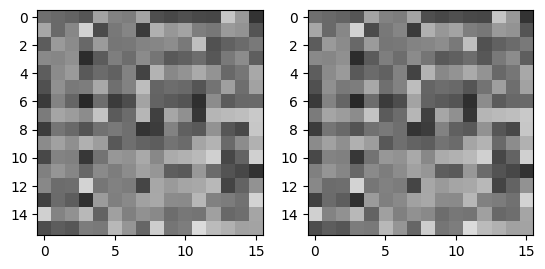

In [53]:
key='s1_0'

srnet: SRNet=getattr(network,key)
sr_res=srnet.model.residual

interp_sample=getattr(lutnet, key+'_sampler')
interp_res=getattr(lutnet, key+'_residual')
interp_res=torch.clamp(interp_res, 0, 1)

assert (sr_res.weights==interp_res).all(), "weights not equal"
assert (srnet.sampler.sampler.weight==interp_sample.sampler.weight).all(), "weights not equal"

def srnet_run(x, prev_x):
    # x: 0~1
    assert srnet.K==srnet.sampler.input_shape
    x, shape = srnet.unfold(x) # B*C*L, 1, K, K
    prev_x, _ = srnet.unfold(prev_x)

    x = srnet.sampler(x)    # B*C*L, 1, 2, 2
    prev_x = srnet.sampler(prev_x)
    # print(f"Network, x:\n{x} \nprev_x:\n{prev_x}")

    # self.model(x, prev_x)
    x = sr_res(x, prev_x)
    return x    # B*C*L, 1, 2, 2

def interp_run(x, prev_x):
    a,b,c,d = lutnet.sample(interp_sample, x)
    res_w = torch.clamp(interp_res, 0, 1)
    oa, ob, oc, od = a, b, c, d
    pa, pb, pc, pd = lutnet.sample(interp_sample, prev_x)
    # print(f"LUT, x: {a.item()} {b.item()} {c.item()} {d.item()}\n prev_x: {pa.item()} {pb.item()} {pc.item()} {pd.item()}")

    a = res_w[0][0]*pa + (1-res_w[0][0])*oa
    b = res_w[0][1]*pb + (1-res_w[0][1])*ob
    c = res_w[1][0]*pc + (1-res_w[1][0])*oc
    d = res_w[1][1]*pd + (1-res_w[1][1])*od

    B, C, H, W = x.shape
    a = a.view(-1, 1, 1, 1) # B*C*L, 1, 1, 1
    b = b.view(-1, 1, 1, 1)
    c = c.view(-1, 1, 1, 1)
    d = d.view(-1, 1, 1, 1)

    upper = torch.cat([a,b], dim=3)
    lower = torch.cat([c,d], dim=3)
    x = torch.cat([upper, lower], dim=2) # B*C*L, 1, 2, 2

    return x

H, W = 10,10
image=torch.rand(1,1,H,W).cuda()
# image = torch.tensor([1,5,3,2,4,6,7,5,3]).view(1,1,H,W).cuda()
image = image / image.max()
prev_image=torch.rand(1,1,H,W).cuda()
# prev_image = torch.tensor([4,6,7,4,3,2,5,7,5]).view(1,1,H,W).cuda()
prev_image = prev_image / prev_image.max()
L = (H - (3-1)) * (W - (3-1))

target_shape = (1,1,(H - (network.sample_size-1))*2,(H - (network.sample_size-1))*2)
sr_out=srnet_run(image, prev_image).reshape(target_shape)
lut_out=interp_run(image, prev_image).reshape(target_shape)

figure, (pa, pb)=plt.subplots(1,2)
showimg(sr_out, pa)
showimg(lut_out, pb)
display(sr_out)
display(lut_out)
(sr_out-lut_out)*255